In [1]:
from pathlib import Path
import json
import numpy as np
import torch
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from affine import Affine
import pandas as pd
import seaborn as sns
from matching.bruteforce import BruteForceMatching
from turbojpeg import TurboJPEG

plt.style.use('dark_background')
jpeg = TurboJPEG()
def read_jpeg(path: Path) -> np.ndarray:
    """Faster than cv2 for jpegs"""
    with open(path, "rb") as f:
        img = jpeg.decode(f.read())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


class Rotator():
    def __init__(self, mat_file) -> None:
        with open(mat_file, "r") as f:
            mats = json.load(f)
        self._mats = {int(k): np.array(v, dtype=np.float64) for k, v in mats.items()}
        self.available_rots = sorted(list(self._mats.keys()))
        self._normed_corners = np.array([
            [0., 0.], [1., 0.],
            [1., 1.], [0., 1.]
        ])

    def rotate(self, image, deg):
        assert deg in self.available_rots
        height, width = image.shape[:2]
        corners = np.array([(0, 0), (width, 0), (width, height), (0, height)], dtype=np.float32)
        rotated_corners_normed = cv2.perspectiveTransform(self._normed_corners[np.newaxis,:], self._mats[deg]).squeeze().astype(np.float32)
        rotated_corners = rotated_corners_normed * corners.max(axis=0)
        H_unnormed = cv2.getPerspectiveTransform(corners, rotated_corners)
        rotated_image = cv2.warpPerspective(image, H_unnormed, (width, height), flags=cv2.INTER_NEAREST)
        return rotated_image


def get_affine(pts1, pts2, thrs):
    if len(pts1) < 2 or len(pts2) < 2:
        return None, np.zeros(len(pts1))

    aff, inl = cv2.estimateAffinePartial2D(pts1, pts2, ransacReprojThreshold=thrs, method=cv2.RANSAC)

    if aff is None:
        return None, np.zeros(len(pts1))

    affine_transform = Affine(
        a=aff[0, 0], b=aff[0, 1], c=aff[0, 2],
        d=aff[1, 0], e=aff[1, 1], f=aff[1, 2],
    )
    inl = inl.squeeze()
    return affine_transform, inl


def get_reprojection_error(pts1, pts2):
    def euclidean_difference(points1, points2):
        return np.sqrt(np.sum((points1 - points2)**2, axis=1))
    differences = euclidean_difference(pts1, pts2)
    return np.mean(differences)


def get_distinct_pts_error(transform, center_only=False):
    if center_only:
        pts = np.array([
            [160, 120]
        ])
    else:
        pts = np.array([
        [0, 0],
        [320, 0],
        [320, 240],
        [0, 240]
    ])
    pts_warp = np.apply_along_axis(lambda x: transform * x, 1, pts)
    error = get_reprojection_error(pts, pts_warp)
    return error


def estimate_metrics(kpts0, kpts1, matches0, ransac_thr=5):
    res = {
        "matched_count": None,
        "matched_error": None,
        "center_error": None,
        "pts0": len(kpts0),
        "pts1": len(kpts1)
    }
    if len(matches0) != 0:
        matched_kpts0 = kpts0[matches0>0]
        matched_kpts1 = kpts1[matches0[matches0>0]]
        res["matched_error"] = get_reprojection_error(matched_kpts0, matched_kpts1)
        res["matched_count"] = sum(matches0>0)

        transform, _ = get_affine(matched_kpts0, matched_kpts1, ransac_thr)
        if transform:
            res["center_error"] = get_distinct_pts_error(transform, center_only=False)
    return res


def plot_angle_stability(ang_results, name):
    fig, axs = plt.subplots(ncols=3, figsize=(20, 3))
    sns.lineplot(data=ang_results.dropna(), x="angle", y="matched_count", ax=axs[0], estimator="median", errorbar=("pi", 50))
    sns.lineplot(data=ang_results.dropna(), x="angle", y="matched_error", ax=axs[1], estimator="median", errorbar=("pi", 50))
    sns.lineplot(data=ang_results.dropna(), x="angle", y="center_error", ax=axs[2], estimator="median", errorbar=("pi", 50))
    axs[0].set_ylabel('Matches')
    axs[1].set_ylabel('Errors in matches')
    axs[2].set_ylabel('Errors in corners')
    for ax in axs:
        ax.set_xlabel(name)
        ax.set_ylim(0, None)


In [2]:
torch.set_grad_enabled(False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))

matching = BruteForceMatching("/home/topkech/work/pytorch-superpoint/logs/cd_100k_edge/checkpoints/superPointNet_35000_checkpoint.pth.tar", use_TTA=False).eval().to(device)


IMG_EXT = ".jpg"
base_path = Path("/home/topkech/work/sat_datasets/cross-domain-compressed")
split = pd.read_csv(base_path/"split.csv").query("split == 'test'")


Running inference on device "cuda"


In [3]:
rotators = {"yaw": Rotator("yaw_mats.json"), "pitch": Rotator("pitch_mats.json"), "roll": Rotator("roll_mats.json")}
results = []
for _, sample in tqdm(split.iterrows(), total=split.shape[0]):
    lr = read_jpeg((base_path/sample["lr_file"]).with_suffix(IMG_EXT))
    hr = read_jpeg((base_path/sample["hr_file"]).with_suffix(IMG_EXT))

    # TODO: sliding window
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2GRAY)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
    lr = cv2.resize(lr, (320, 240), interpolation=cv2.INTER_NEAREST)
    hr = cv2.resize(hr, (320, 240), interpolation=cv2.INTER_NEAREST)
    for axis, rotator in rotators.items():
        for angle in rotator.available_rots:
            hr_rot = rotator.rotate(hr, angle)
            pred = matching({"image0": torch.tensor(lr/255, dtype=torch.float32, device=device).view(1, 1, 240, 320), "image1": torch.tensor(hr_rot/255, dtype=torch.float32, device=device).view(1, 1, 240, 320)})
            kpts0, kpts1, matches = pred['pts_int0'], pred['pts_int1'], pred['matches0']
            metrics = estimate_metrics(kpts0, kpts1, matches)
            metrics["angle"] = angle
            metrics["axis"] = axis
            results.append({**sample.to_dict(), **metrics})

res = pd.DataFrame(results)


  0%|          | 0/1458 [00:00<?, ?it/s]/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 54%|█████▍    | 789/1458 [16:26<15:24,  1.38s/it]/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1458/1458 [28:54<00:00,  1.19s/it]


In [8]:
res = pd.DataFrame(results)
res = res[~res["hr_file"].str.contains("openaerialmap")]
# res = res[~res["hr_file"].str.contains("satellite")]
# res = res[~res["hr_file"].str.contains("maxar")]
res = res[~res["hr_file"].str.contains("flair")]
# res = res.query("angle == 0")
res


,split,stack_name,group_num,hr_file,lr_file,valid_mask_file,matched_count,matched_error,center_error,pts0,pts1,angle,axis
1247,test,ard_37_031133023310_2023-02-11_10300100E18CB60...,2,maxar/maxar/ard_37_031133023310_2023-02-11_103...,maxar/planet/ard_37_031133023310_2023-02-11_10...,maxar/valid_mask/ard_37_031133023310_2023-02-1...,200.0,24.825590,33.249610,385,534,-10,yaw
1248,test,ard_37_031133023310_2023-02-11_10300100E18CB60...,2,maxar/maxar/ard_37_031133023310_2023-02-11_103...,maxar/planet/ard_37_031133023310_2023-02-11_10...,maxar/valid_mask/ard_37_031133023310_2023-02-1...,208.0,22.135159,31.650209,385,527,-9,yaw
1249,test,ard_37_031133023310_2023-02-11_10300100E18CB60...,2,maxar/maxar/ard_37_031133023310_2023-02-11_103...,maxar/planet/ard_37_031133023310_2023-02-11_10...,maxar/valid_mask/ard_37_031133023310_2023-02-1...,219.0,20.464827,29.877943,385,521,-8,yaw
1250,test,ard_37_031133023310_2023-02-11_10300100E18CB60...,2,maxar/maxar/ard_37_031133023310_2023-02-11_103...,maxar/planet/ard_37_031133023310_2023-02-11_10...,maxar/valid_mask/ard_37_031133023310_2023-02-1...,227.0,18.890272,27.480735,385,540,-7,yaw
1251,test,ard_37_031133023310_2023-02-11_10300100E18CB60...,2,maxar/maxar/ard_37_031133023310_2023-02-11_103...,maxar/planet/ard_37_031133023310_2023-02-11_10...,maxar/valid_mask/ard_37_031133023310_2023-02-1...,231.0,16.181183,32.505543,385,552,-6,yaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55852,test,SatNav_RazdolneCrimea_2023-10-23_skysatcollect...,10,satellites/skysat/SatNav_RazdolneCrimea_2023-1...,satellites/other/SatNav_RazdolneCrimea_2023-10...,satellites/valid_mask/SatNav_RazdolneCrimea_20...,36.0,6.829591,1.959188,55,67,1,roll
55853,test,SatNav_RazdolneCrimea_2023-10-23_skysatcollect...,10,satellites/skysat/SatNav_RazdolneCrimea_2023-1...,satellites/other/SatNav_RazdolneCrimea_2023-10...,satellites/valid_mask/SatNav_RazdolneCrimea_20...,35.0,4.854810,4.377078,55,80,2,roll
55854,test,SatNav_RazdolneCrimea_2023-10-23_skysatcollect...,10,satellites/skysat/SatNav_RazdolneCrimea_2023-1...,satellites/other/SatNav_RazdolneCrimea_2023-10...,satellites/valid_mask/SatNav_RazdolneCrimea_20...,43.0,9.045314,11.141967,55,81,3,roll
55855,test,SatNav_RazdolneCrimea_2023-10-23_skysatcollect...,10,satellites/skysat/SatNav_RazdolneCrimea_2023-1...,satellites/other/SatNav_RazdolneCrimea_2023-10...,satellites/valid_mask/SatNav_RazdolneCrimea_20...,38.0,10.834496,8.338684,55,71,4,roll


<Axes: ylabel='Frequency'>

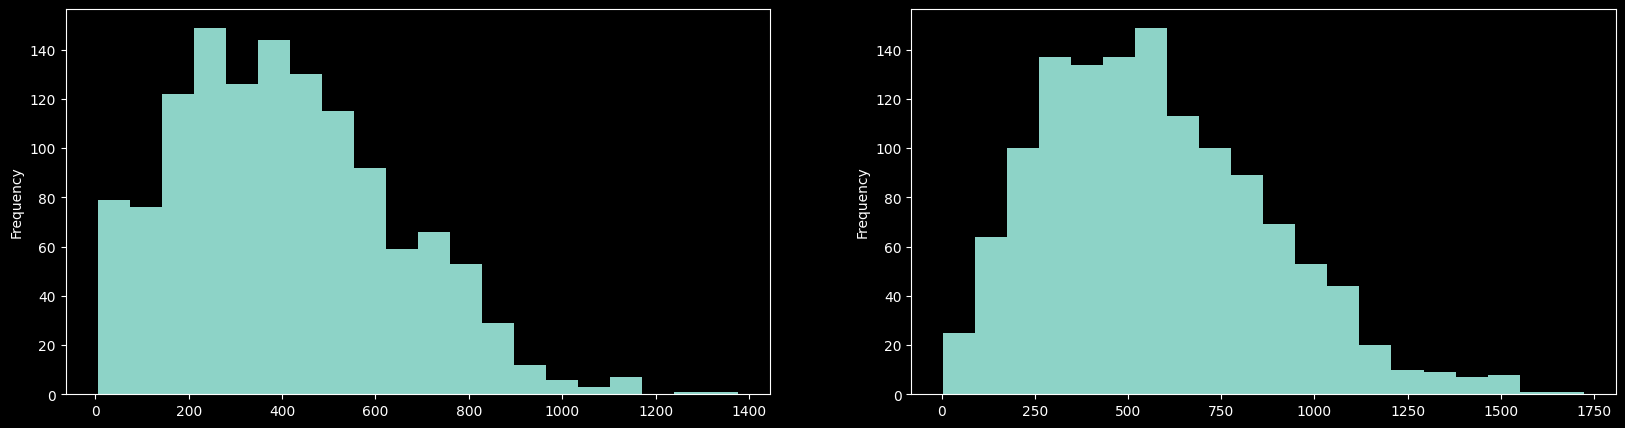

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
simple_results = res.query("angle == 0").drop(columns="axis").drop_duplicates()
simple_results["pts0"].plot.hist(ax=axs[0], bins=20)
simple_results["pts1"].plot.hist(ax=axs[1], bins=20)


Text(0, 0.5, 'misses')

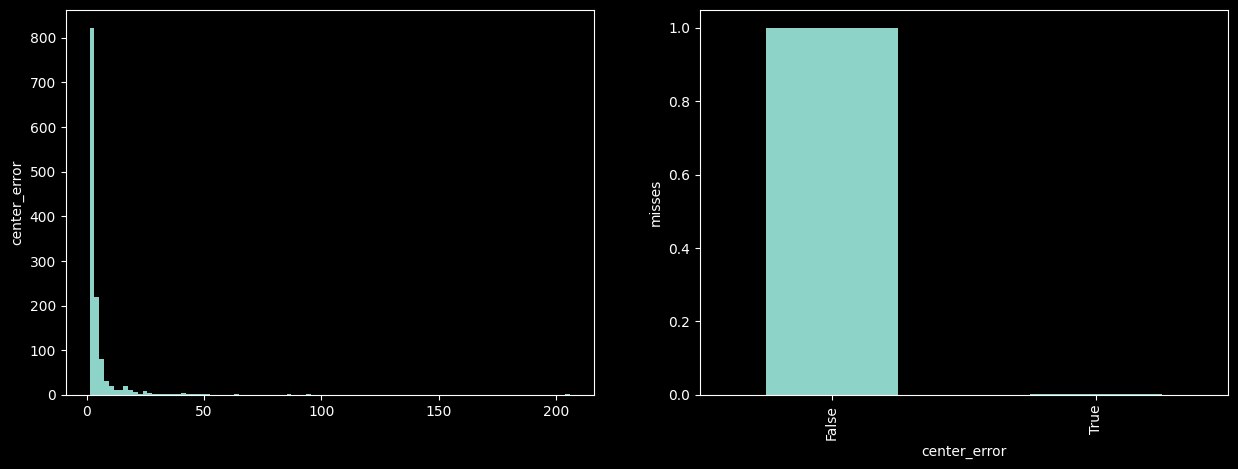

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
simple_results = res.query("angle == 0").drop(columns="axis").drop_duplicates()
# simple_results.loc[simple_results["center_error"] > 50, "center_error"] = 50
simple_results["matched_error"].plot.hist(bins=100, ax=axs[0])
misses = simple_results["center_error"].isna().value_counts() / simple_results.shape[0]
misses.plot.bar(axs[1])

axs[0].set_ylabel("center_error")
axs[1].set_ylabel("misses")


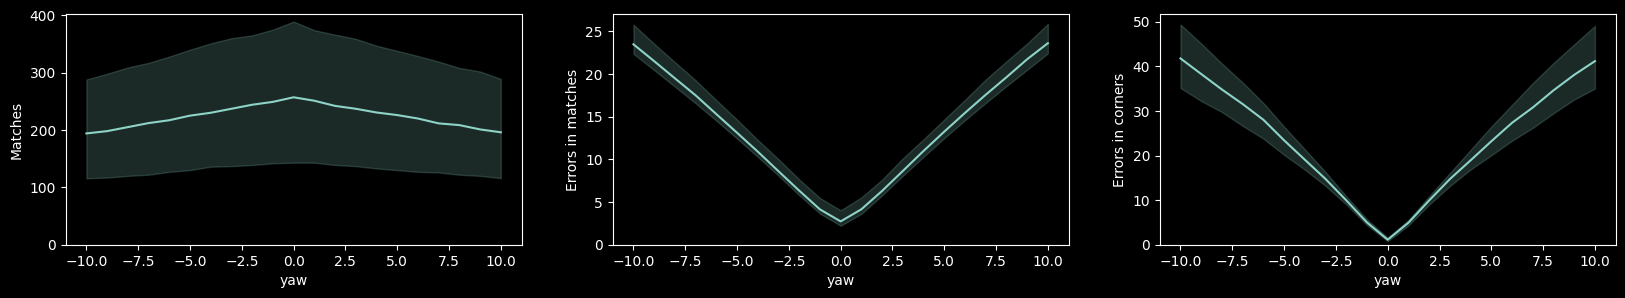

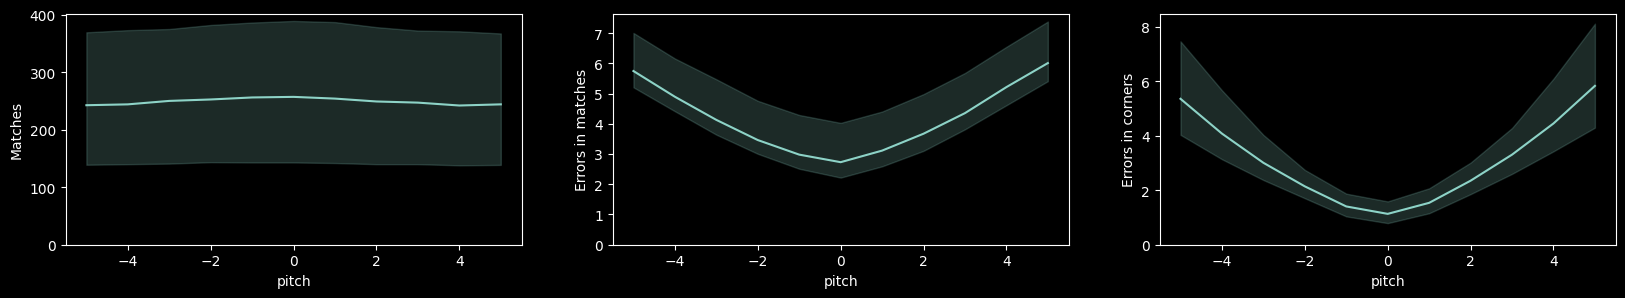

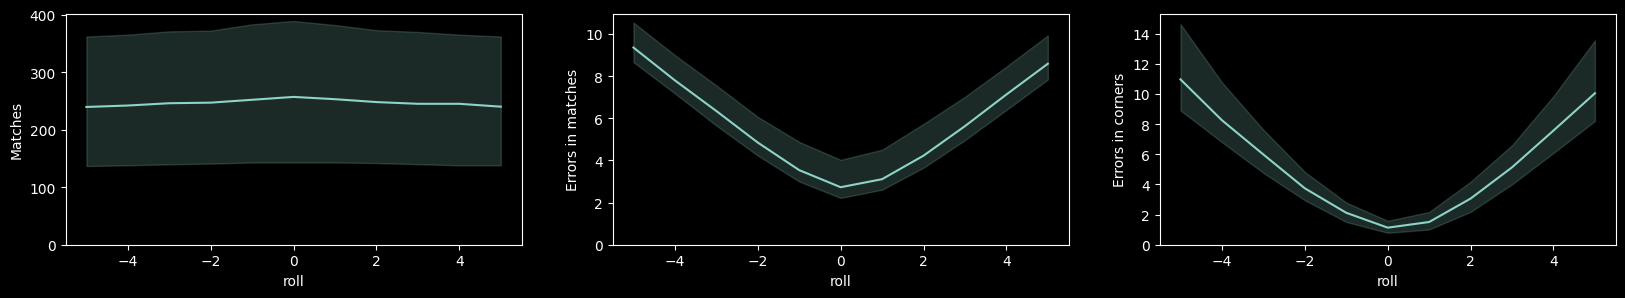

In [11]:
yaw_results = res.query("axis == 'yaw'")
pitch_results = res.query("axis == 'pitch'")
roll_results = res.query("axis == 'roll'")
plot_angle_stability(yaw_results, "yaw")
plot_angle_stability(pitch_results, "pitch")
plot_angle_stability(roll_results, "roll")


In [18]:
from matching.superpoint.superpointnet import SuperPointNet, flattenDetection
sp = SuperPointNet("/home/topkech/work/pytorch-superpoint/logs/cd_100k_edge/checkpoints/superPointNet_43000_checkpoint.pth.tar")
sp.eval()
sp.cuda()

for _, sample in tqdm(split.iterrows(), total=split.shape[0]):
    lr = read_jpeg((base_path/sample["lr_file"]).with_suffix(IMG_EXT))
    hr = read_jpeg((base_path/sample["hr_file"]).with_suffix(IMG_EXT))

    # TODO: sliding window
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2GRAY)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
    lr = cv2.resize(lr, (320, 240), interpolation=cv2.INTER_NEAREST)
    hr = cv2.resize(hr, (320, 240), interpolation=cv2.INTER_NEAREST)
    hr = torch.tensor(hr/255, device="cuda", dtype=torch.float32).view(1,1,240,320)
    lr = torch.tensor(lr/255, device="cuda", dtype=torch.float32).view(1,1,240,320)
    semilr, desclr = sp(lr)
    semihr, deschr = sp(hr)
    break


  0%|          | 0/1458 [00:00<?, ?it/s]


In [19]:
heatmaplr = flattenDetection(semilr)
heatmaphr = flattenDetection(semihr)


In [39]:
sum([p.numel() for p in sp.parameters()])


1304067